In [9]:
install.packages('readr')
library(readr)

also installing the dependency ‘hms’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [ ]:
install.packages('dplyr')

In [24]:
install.packages('knitr')
library(knitr)

also installing the dependencies ‘mime’, ‘highr’, ‘markdown’, ‘yaml’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [23]:
customers <- read_csv("/home/dupad/Desktop/bikeshops.csv")
products <- read_csv("/home/dupad/Desktop/bikes.csv") 
orders <- read_csv("/home/dupad/Desktop/orders.csv")

Parsed with column specification:
cols(
  bikeshop.id = col_integer(),
  bikeshop.name = col_character(),
  bikeshop.city = col_character(),
  bikeshop.state = col_character(),
  latitude = col_double(),
  longitude = col_double()
)
Parsed with column specification:
cols(
  bike.id = col_integer(),
  model = col_character(),
  category1 = col_character(),
  category2 = col_character(),
  frame = col_character(),
  price = col_integer()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  order.id = col_integer(),
  order.line = col_integer(),
  order.date = col_character(),
  customer.id = col_integer(),
  product.id = col_integer(),
  quantity = col_integer()
)


In [25]:
# Combine orders, customers, and products data frames
library(dplyr)
orders.extended <- merge(orders, customers, by.x = "customer.id", by.y="bikeshop.id")
orders.extended <- merge(orders.extended, products, by.x = "product.id", by.y = "bike.id")

orders.extended <- orders.extended %>% mutate(price.extended = price * quantity) %>% select(order.date, order.id, order.line, bikeshop.name, model,quantity, price, price.extended, category1, category2, frame) %>% arrange(order.id, order.line)

knitr::kable(head(orders.extended)) # Preview the data



|order.date | order.id| order.line|bikeshop.name             |model                    | quantity| price| price.extended|category1 |category2     |frame    |
|:----------|--------:|----------:|:-------------------------|:------------------------|--------:|-----:|--------------:|:---------|:-------------|:--------|
|1/7/2011   |        1|          1|Ithaca Mountain Climbers  |Jekyll Carbon 2          |        1|  6070|           6070|Mountain  |Over Mountain |Carbon   |
|1/7/2011   |        1|          2|Ithaca Mountain Climbers  |Trigger Carbon 2         |        1|  5970|           5970|Mountain  |Over Mountain |Carbon   |
|1/10/2011  |        2|          1|Kansas City 29ers         |Beast of the East 1      |        1|  2770|           2770|Mountain  |Trail         |Aluminum |
|1/10/2011  |        2|          2|Kansas City 29ers         |Trigger Carbon 2         |        1|  5970|           5970|Mountain  |Over Mountain |Carbon   |
|1/10/2011  |        3|          1|Louisville Race

In [26]:
# Group by model & model features, summarize by quantity purchased
install.packages('tidyr')
library(tidyr)  # Needed for spread function

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [27]:
customerTrends <- orders.extended %>%
        group_by(bikeshop.name, model, category1, category2, frame, price) %>%
        summarise(total.qty = sum(quantity)) %>%
        spread(bikeshop.name, total.qty)
customerTrends[is.na(customerTrends)] <- 0  # Remove NA's

In [29]:
# Convert price to binary high/low category
install.packages('Hmisc')
library(Hmisc)  # Needed for cut2 function

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘rstudioapi’, ‘Formula’, ‘latticeExtra’, ‘cluster’, ‘acepack’, ‘foreign’, ‘gridExtra’, ‘htmlTable’, ‘viridis’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units



In [30]:
customerTrends$price <- cut2(customerTrends$price, g=2) 

In [31]:
# Convert customer purchase quantity to percentage of total quantity
customerTrends.mat <- as.matrix(customerTrends[,-(1:5)])  # Drop first five columns
customerTrends.mat <- prop.table(customerTrends.mat, margin = 2)  # column-wise pct
customerTrends <- bind_cols(customerTrends[,1:5], as.data.frame(customerTrends.mat))

In [32]:
# View data post manipulation
knitr::kable(head(customerTrends))



|model               |category1 |category2  |frame    |price        | Albuquerque Cycles| Ann Arbor Speed| Austin Cruisers| Cincinnati Speed| Columbus Race Equipment| Dallas Cycles| Denver Bike Shop| Detroit Cycles| Indianapolis Velocipedes| Ithaca Mountain Climbers| Kansas City 29ers| Las Vegas Cycles| Los Angeles Cycles| Louisville Race Equipment| Miami Race Equipment| Minneapolis Bike Shop| Nashville Cruisers| New Orleans Velocipedes| New York Cycles| Oklahoma City Race Equipment| Philadelphia Bike Shop| Phoenix Bi-peds| Pittsburgh Mountain Machines| Portland Bi-peds| Providence Bi-peds| San Antonio Bike Shop| San Francisco Cruisers| Seattle Race Equipment| Tampa 29ers| Wichita Speed|
|:-------------------|:---------|:----------|:--------|:------------|------------------:|---------------:|---------------:|----------------:|-----------------------:|-------------:|----------------:|--------------:|------------------------:|------------------------:|-----------------:|---------------

In [33]:
# Running the k-means algorithm
install.packages("cluster") # Needed for silhouette function
library(cluster)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


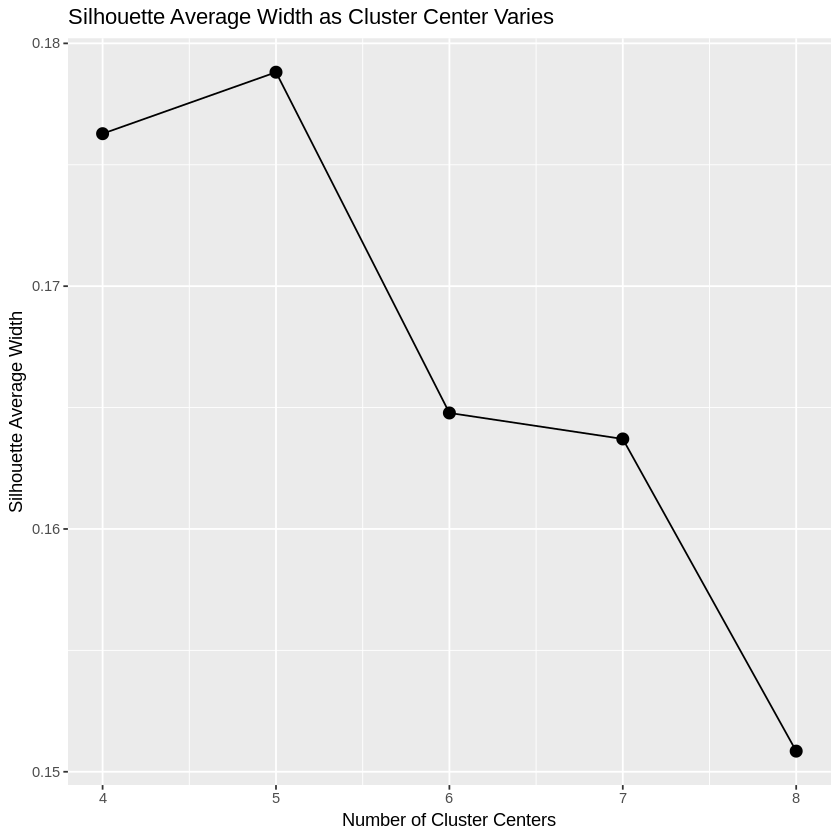

In [35]:
kmeansDat <- customerTrends[,-(1:5)]  # Extract only customer columns
kmeansDat.t <- t(kmeansDat)  # Get customers in rows and products in columns

# Setup for k-means loop 
km.out <- list()
sil.out <- list()
x <- vector()
y <- vector()
minClust <- 4      # Hypothesized minimum number of segments
maxClust <- 8      # Hypothesized maximum number of segments

# Compute k-means clustering over various clusters, k, from minClust to maxClust
for (centr in minClust:maxClust) {
        i <- centr-(minClust-1) # relevels start as 1, and increases with centr
        set.seed(11) # For reproducibility
        km.out[i] <- list(kmeans(kmeansDat.t, centers = centr, nstart = 50))
        sil.out[i] <- list(silhouette(km.out[[i]][[1]], dist(kmeansDat.t)))
        # Used for plotting silhouette average widths
        x[i] = centr  # value of k
        y[i] = summary(sil.out[[i]])[[4]]  # Silhouette average width
}
#Next, we plot the silhouette average widths for the choice of clusters. The best cluster is the one with the largest silhouette average width, which turns out to be 5 clusters.

# Plot silhouette results to find best number of clusters; closer to 1 is better
library(ggplot2)
ggplot(data = data.frame(x, y), aes(x, y)) + 
  geom_point(size=3) + 
  geom_line() +
  xlab("Number of Cluster Centers") +
  ylab("Silhouette Average Width") +
  ggtitle("Silhouette Average Width as Cluster Center Varies")

In [ ]:
# Get customer names that are in each segment ----------------------------------

# Get attributes of optimal k-means output
maxSilRow <- which.max(y)          # Row number of max silhouette value
optimalClusters <- x[maxSilRow]    # Number of clusters
km.out.best <- km.out[[maxSilRow]] # k-means output of best cluster

# Create list of customer names for each cluster
clusterNames <- list()
clusterList <- list()
for (clustr in 1:optimalClusters) {
  clusterNames[clustr] <- paste0("X", clustr)
  clusterList[clustr] <- list(
    names(
        km.out.best$cluster[km.out.best$cluster == clustr]
        )
    )
}
names(clusterList) <- clusterNames

print(clusterList)

In [ ]:
# Combine cluster centroids with bike models for feature inspection ------------
custSegmentCntrs <- t(km.out.best$centers)  # Get centroids for groups
colnames(custSegmentCntrs) <- make.names(colnames(custSegmentCntrs))
customerTrends.clustered <- bind_cols(customerTrends[,1:5], as.data.frame(custSegmentCntrs))

In [ ]:
# Arrange top 10 bike models by cluster in descending order --------------------
attach(customerTrends.clustered)  # Allows ordering by column name
knitr::kable(head(customerTrends.clustered[order(-X1), c(1:5, 6)], 10))

In [ ]:
# Arrange top 10 bike models by cluster in descending order
knitr::kable(head(customerTrends.clustered[order(-X2), c(1:5, 7)], 10))

In [ ]:
detach(customerTrends.clustered)